# Loading Stats SA ASCII-formatted time series data

## Introduction

Statistics South Africa (Stats SA) is the government statistician here in South Africa. They publish stats about the economy, standard of living, the performance of local government, and lots of other stuff. If you're interested in finding out the state of South Africa in cold hard numbers, head over to [http://www.statssa.gov.za/](http://www.statssa.gov.za/).

Most of their data is, unfortunately, locked up in reports that can be downloaded as PDFs - i.e. not that easy to do one's own analyses. Sometimes, they do make time series data available though. When time series data is available for download, its provided in two formats: Excel work books and ASCII files. Working with Excel is easy, but I feel like a challenge and I feel like avoiding Excel. That's why this notebook will focus on making a function to parse the ASCII files made available by Stats SA. I'll be putting this function to use in subsequent notebooks to make some interesting analyses of Stats SA data.

This notebook and related data can be downloaded from my repository for Stats SA-related blog posts: [StatsSA-blog](https://bitbucket.org/williamjshipman/statssa-blog)

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
from os.path import expanduser
from datetime import date
import seaborn as sns

/home/wjs/opt/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## The first stage - ASCII to a data structure

My first step is going to be to transform the text file into a list of time series structures. The basic structure of each time series is a sequence of meta-data lines followed by the actual values, one per line.

The meta-data lines start with tag Hxx (e.g. H01, H13), which is followed by some text. The actual data follows the meta-data, with each value in the time series printed on a new line. The end of the time series is indicated either by the end of the text file or by the appearance of a new meta-data line.

In [3]:
all_time_series = []
with open(expanduser('./data/CPI/ASCII Consumer Price Index - Jan 2008 to Nov 2015.txt'), 'r') as inputfile:
    for inputline in inputfile:
        if inputline[0] == 'H': # This is a meta-data field.
            tag, sep, value = inputline.partition(': ')
            if tag == 'H01':
                all_time_series += [{'data':[], 'tags':{}}]
            all_time_series[-1]['tags'][tag] = value.strip()
        else:
            all_time_series[-1]['data'] += [float(inputline)]

In [4]:
len(all_time_series)

978

In [5]:
all_time_series[0]['tags']

{'H01': 'P0141',
 'H02': 'Consumer Price Index',
 'H03': 'CPA00000',
 'H04': 'All Items',
 'H05': '',
 'H06': '',
 'H13': 'Western Cape',
 'H14': '',
 'H17': 'Index',
 'H18': 'Dec 2012 = 100',
 'H23': 'RELEASE: 2015 11',
 'H24': 'START: 2008 01',
 'H25': 'monthly'}

The tag H01 gives the publication number, while H02 gives the title associated with that publication. In this case, I'm looking at the Consumer Price Index in South Africa. The data doesn't just give the overall CPI though. It also gives CPI for different baskets of goods in each province. The basket of goods is indicated by the H04 tag, e.g. 'All items', 'Clothing' or 'Tobacco' are some of the baskets for which CPI is calculated. The H13 tag tells us which province the time series applies to, or if it applies to the whole of South Africa.

## Making Pandas Series objects

Now that each time series has been extracted, the next step is to construct some Pandas Series objects, one for each time series. You'll see that the Stats SA data specifies the start date for a time series and an update frequency e.g. monthly. These need to be turned into a DateRange that can be used as an index into the Series.

In [6]:
for tsdata in all_time_series:
    if tsdata['tags']['H25'].strip() == 'monthly':
        _, start_year, start_month = tsdata['tags']['H24'].split(' ')
        index = pd.date_range(start=date(int(start_year), int(start_month), 1), freq='M', periods=len(tsdata['data']))
        tsdata['series'] = pd.Series(tsdata['data'],
                                     index=index,
                                     name='{code:s} {quant:s} ({province:s}) - {detail:s}'.format(
                                        code=tsdata['tags']['H01'],
                                        quant=tsdata['tags']['H02'],
                                        detail=tsdata['tags']['H04'],
                                        province=tsdata['tags']['H13']))

## Plotting the data

Plotting the data shows that some of the indices have actually suffered deflation since 2008, but I'll look at that in another post. You'll also see that all the series converge at December 2012. That is because I'm plotting Consumper Price Index time series. These indices are all relative to December 2012, which was chosen to be the value 100. What this means is that if in January 2008 the index was at 300 for one of the time series, the price of that basket of goods was three times higher than in December 2015.

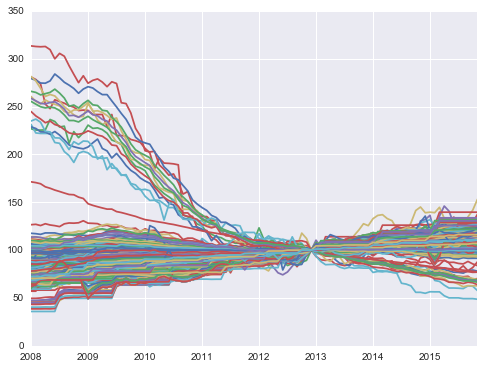

In [7]:
sns.plt.figure(figsize=(8,6))
for tsdata in all_time_series:
    tsdata['series'].plot()
sns.plt.show()

## Putting it into a DataFrame

All of these time series have the same date range and frequency, i.e. monthly. Therefore, they can be combined into a single DataFrame. Here I'm going to make each time series into one column of the DataFrame. The column indices will be hierarchichal, using the province and detail, i.e. H13 and H04 tags.

In [8]:
df_data = {(tsdata['tags']['H13'], tsdata['tags']['H04']): tsdata['series'] for tsdata in all_time_series}
df = pd.DataFrame(data=df_data)
df

All urban areas                      \
           Actual rentals for housing Alcoholic beverages   
2008-01-31                       76.4                69.4   
2008-02-29                       76.4                70.8   
2008-03-31                       78.3                73.3   
2008-04-30                       78.3                73.7   
2008-05-31                       78.3                74.0   
2008-06-30                       80.4                74.2   
2008-07-31                       80.4                74.4   
2008-08-31                       80.4                74.6   
2008-09-30                       81.3                75.1   
2008-10-31                       81.3                75.1   
2008-11-30                       81.3                75.1   
2008-12-31                       82.5                75.1   
2009-01-31                       82.5                75.4   
2009-02-28                       82.5                76.1   
2009-03-31                       83.4                79.8   
2009-04-30                       83.4                80.5   
2009-05-31                       83.4                80.7   
2009-06-30                       84.9                80.6   
2009-07-31                       84.9                80.8   
2009-08-31                       84.9                80.8   
2009-09-30                       85.7                81.0   
2009-10-31                       85.7                81.0   
2009-11-30                       85.7                81.0   
2009-12-31                       86.5                80.9   
2010-01-31                       86.5                81.1   
2010-02-28                       86.5                81.2   
2010-03-31                       87.4                85.2   
2010-04-30                       87.4                85.5   
2010-05-31                       87.4                85.9   
2010-06-30                       88.7                85.7   
...                               ...                 ...   
2013-06-30                      102.7               106.3   
2013-07-31                      102.7               106.8   
2013-08-31                      102.7               106.6   
2013-09-30                      103.9               107.0   
2013-10-31                      103.9               108.0   
2013-11-30                      103.9               107.6   
2013-12-31                      105.0               107.6   
2014-01-31                      105.0               108.5   
2014-02-28                      105.0               108.9   
2014-03-31                      106.4               110.7   
2014-04-30                      106.4               111.5   
2014-05-31                      106.4               112.2   
2014-06-30                      108.0               112.5   
2014-07-31                      108.0               112.4   
2014-08-31                      108.0               112.6   
2014-09-30                      109.3               112.7   
2014-10-31                      109.3               114.8   
2014-11-30                      109.3               115.4   
2014-12-31                      110.3               115.4   
2015-01-31                      110.3               116.1   
2015-02-28                      110.3               117.7   
2015-03-31                      112.0               120.7   
2015-04-30                      112.0               122.3   
2015-05-31                      112.0               123.2   
2015-06-30                      113.2               123.5   
2015-07-31                      113.2               123.8   
2015-08-31                      113.2               124.1   
2015-09-30                      114.7               124.3   
2015-10-31                      114.7               124.5   
2015-11-30                      114.7               124.6   

                                            \
           Alcoholic beverages and tobacco   
2008-01-31                            67.0   
2008-02-29                            67

## What's next

Now that I can load the CPI data, I intend doing some more analysis in a future blog post. I'm also going to turn the code here into a decent function (or two) that will give me all the series and the DataFrame. I still need to handle frequencies other than monthly when loading the time series, e.g. quarterly and annually.